# Training, Evaluating and Comparing Models

In this notebook, different model architectures will be trained on the main data
as well as on the integrated data. All models will be evaluated, and finally
compared to another to select the best performing one.

Here, the train, val and test data is just loaded from files.
The data analysis and preparation was done in the notebook
`01-data_preparation.ipynb`.

## Preparations

In [11]:
# dependencies
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb

from sklearn.model_selection import GridSearchCV

# paths
PATH_DATA = Path("../data/processed/main/")
PATH_MODELS = Path("../models/")

In [2]:
# load data

# train data
X_train = pd.read_csv(PATH_DATA / "sleep_data_main_train_features.csv")
y_train = pd.read_csv(PATH_DATA / "sleep_data_main_train_labels.csv")

# test data
X_test = pd.read_csv(PATH_DATA / "sleep_data_main_test_features.csv")
y_test = pd.read_csv(PATH_DATA / "sleep_data_main_test_labels.csv")

# no validation data used, because models are tuned using cross validation

In [3]:
# define function to train model with grid search
def train_model_with_gridsearch(row):
    """
    Train model using GridSearchCV and return best results.
    
    Parameters:
    -----------
    row: pd.Series
        A row from the data frame containing the model and its parameter grid.
    
    Returns:
    --------
    pd.Series
        A series with the best parameters, best RMSE and best model.
    """
    
    # setup grid search
    grid_search = GridSearchCV(
        estimator=row['model'],
        param_grid=row['param_grid'],
        scoring='neg_root_mean_squared_error',  # sklearn uses negative RMSE
        cv=5,                                   # 5-fold cross-validation
        n_jobs=-1,                              # use all cores
        verbose=1
    )
    
    # fit grid search
    grid_search.fit(X_train, y_train.squeeze())
    
    # get best results and convert back to positive RMSE
    best_rmse = -grid_search.best_score_
    # get std of best model
    rmse_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    
    return pd.Series({
        'best_params': grid_search.best_params_,
        'best_rmse': round(best_rmse, 4),
        'rmse_std': round(rmse_std, 4),
        'best_model': grid_search.best_estimator_
    })

In [4]:
# after selecting final model
def evaluate_final_model(best_model):
    """Only use test set once at the very end."""
    test_pred = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    return test_rmse

## Hyperparameter Tuning Using Grid Search

Solve it using Scikit-Learn's built in function for grid search.
Scikit learn has a function for this that should be used.

Use cross-validation for all model selection/comparison.
No validation set is needed here.

The data I use for this project is kind of tiny.
The main version has just 500 rows, and the integrated version has just a few
hundred more.
I can afford to make a huge grid here and try many different algorithms.
If the data was larger, I couldn't afford this, but it isn't.
So, I can just go for it.

### Explanation of Grid

This grid provides a good balance between:

- Simple and complex models
- Overfitting prevention and model flexibility
    - Small dataset size → more focus on preventing overfitting
    - Synthetic data → included both simple and complex models
- Computation time and thoroughness of search
- Different approaches to handling the multi-modal target

1. Linear Regression

- Simplest model, serves as baseline
- Limited parameters but important to test both with/without intercept
- Positive constraint might help if relationships are known to be positive

2. Ridge Regression

- Good for small data sets
- Adds L2 regularization to linear regression
- Wide range of alpha values to find optimal regularization
- Small alpha values allow model to be close to linear regression
- Large alpha values force coefficients toward zero

3. Elastic Net

- Good for small data sets
- Combines L1 and L2 regularization
- l1_ratio=0 is Ridge, l1_ratio=1 is Lasso
- Good for feature selection and handling correlated features

4. Decision Tree

- Single tree model, good for interpretability
- max_depth controls complexity (None means unlimited)
- min_samples parameters prevent overfitting
- max_features options help with feature selection

5. Random Forest

- Ensemble of trees using bagging
- More trees generally better but with diminishing returns
- bootstrap controls whether to use sampling with replacement
- Other parameters similar to single tree but can be less restrictive

6. Extra Trees

- Similar to Random Forest but with random splits
- Generally needs more trees due to increased randomness
- Often better at preventing overfitting
- Parameters similar to Random Forest

7. XGBoost

- learning_rate controls how much each tree contributes
- subsample and colsample help prevent overfitting
- min_child_weight and gamma provide additional regularization
- Generally needs more careful tuning than other models

In [5]:
# create dataframe with models and their parameter grids
# make the grid
models_df = pd.DataFrame([
    {
        'name': 'linear_regression',
        'model': LinearRegression(),
        'param_grid': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        }
    },
    {
        'name': 'ridge',
        'model': Ridge(random_state=1337),
        'param_grid': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'fit_intercept': [True, False]
        }
    },
    {
        'name': 'elastic_net',
        'model': ElasticNet(random_state=1337),
        'param_grid': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'fit_intercept': [True, False]
        }
    },
    {
        'name': 'decision_tree',
        'model': DecisionTreeRegressor(random_state=1337),
        'param_grid': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'random_forest',
        'model': RandomForestRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    {
        'name': 'extra_trees',
        'model': ExtraTreesRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'xgboost',
        'model': xgb.XGBRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 4, 5, 6, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2]
        }
    }
])

# show the grid
models_df

,name,model,param_grid
0,linear_regression,LinearRegression(),"{'fit_intercept': [True, False], 'positive': [..."
1,ridge,Ridge(random_state=1337),"{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0..."
2,elastic_net,ElasticNet(random_state=1337),"{'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio':..."
3,decision_tree,DecisionTreeRegressor(random_state=1337),"{'max_depth': [3, 5, 7, 10, None], 'min_sample..."
4,random_forest,"RandomForestRegressor(n_jobs=-1, random_state=...","{'n_estimators': [50, 100, 200, 300], 'max_dep..."
5,extra_trees,"ExtraTreesRegressor(n_jobs=-1, random_state=1337)","{'n_estimators': [50, 100, 200, 300], 'max_dep..."
6,xgboost,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': [50, 100, 200, 300], 'max_dep..."


In [ ]:
# apply grid search to each model
results = models_df.apply(train_model_with_gridsearch, axis=1)
ﬂﬂı
# add results to models_df
models_df = pd.concat([models_df, results], axis=1)

# print results: Model, best parameters and corresponding RMSE
for _, row in models_df.iterrows():
    print(f"\nModel: {row['name']}")
    print(f"Best parameters: {row['best_params']}")
    print(f"Best RMSE: {row['best_rmse']} ± {row['rmse_std']}")

In [7]:
# print results: Model, best parameters and corresponding RMSE
for _, row in models_df.iterrows():
    print(f"\nModel: {row['name']}")
    print(f"Best parameters: {row['best_params']}")
    print(f"Best RMSE: {row['best_rmse']} ± {row['rmse_std']}")


Model: linear_regression
Best parameters: {'fit_intercept': True, 'positive': True}
Best RMSE: 0.3381 ± 0.0144

Model: ridge
Best parameters: {'alpha': 10.0, 'fit_intercept': True}
Best RMSE: 0.3395 ± 0.0166

Model: elastic_net
Best parameters: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.3}
Best RMSE: 0.3301 ± 0.0133

Model: decision_tree
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}
Best RMSE: 0.3491 ± 0.0247

Model: random_forest
Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: 0.3356 ± 0.015

Model: extra_trees
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 0.3321 ± 0.0145

Model: xgboost
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50

Even with this extensive grid and multiple ten thousands of fits, for this small
data set the computation time was mere 4 min and 17.5 s on my machine.
As I said, with a larger data set, the grid would have to be significantly
reduced in size. Here, however, it's possible to do this.

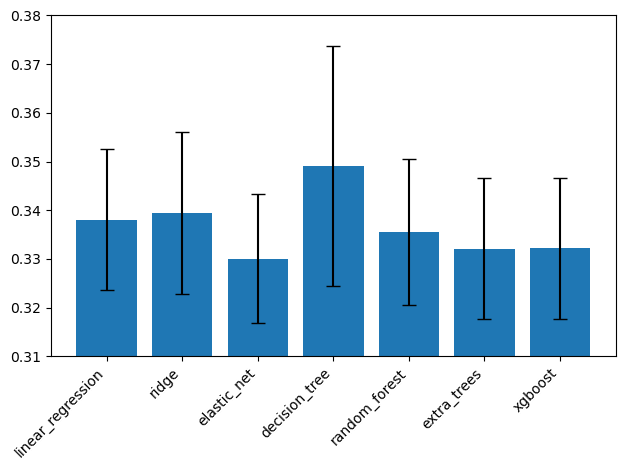

In [33]:
# get data for plotting
results_visualization = models_df[["name", "best_rmse", "rmse_std"]]

# plot results
plt.bar(
    x=range(len(results_visualization)),
    height=results_visualization["best_rmse"],
    yerr=results_visualization["rmse_std"],
    capsize=5,
    tick_label=results_visualization["name"]
)

# set y-axis range
plt.ylim(0.31, 0.38) 

# rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# adjust layout to prevent label cutoff
plt.tight_layout()

#### Choose final model based on CV results and practical considerations

All model's performance is similar. 
It's actually really close.
Elastic Nets have a slight edge here.
This may be due to more regularization, which is good for small data sets.

Things to consider for selecting a model:

- If difference in rmse is small, prefer simpler models
- Elastic net is best regarding here RMSE, but I want feature importance to find out which features have greatest influence on sleep quality. Trees are better for this.
This is a large part of what's interesting about the project in the first place
- If you choose a model with slightly worse (higher) RMSE, it's fine, but the difference should not exceed 5%
- I can also stack models as ensemble using StackingRegressor
- If models were larger, prediction / inference speed would become a factor to consider, but all these are pretty tiny

- Extra Trees and XGBoost perform slightly better than Random Forest here.
- Extra Trees is generally less complex than XGBoost
- Extra Trees is less prone to overfitting
- Extra Trees tends to be more reliable and stable regarding feature importance
    - Averages across many independent trees
    - Less prone to bias compared to boosting methods
    - More consistent across different runs due to randomized nature
- XGBoost's feature importance may be somewhat less reliable under certain circumstances
    - More sensitive to parameter tuning
    - Sometimes biased towards continuous features or high cardinality categorical features
    - Less stable across different runs due to the sequential nature of boosting

In [60]:
# compare the difference in performance between Extra Trees and Elastic Nets
rmse_elastic_net = 0.3301
rmse_extra_trees = 0.3321

# calculate absolute difference
absolute_difference = abs(rmse_elastic_net - rmse_extra_trees)

# calculate percentage difference
percentage_difference = (absolute_difference / rmse_elastic_net) * 100

print(f"Percentage difference: {percentage_difference:.2f}%")

Percentage difference: 0.61%



##### Conclusion

The best option is probably Extra Trees.

- While its RMSE is slightly larger than that of Elastic Nets, the difference
is just 0.61%
- It allows for easily accessing feature importance and is more reliable than
XGBoost regarding this
- It is simpler than XGBoost, so it's preferrable if performance is equally good

Another option is to use Extra Trees for feature importance and use a stacked
model ensemble of Extra Trees and Elastic Nets for prediction.

However, I didn't evaluate that so far. I think it may be speculative if it
yields improved results, and I should have evaluated it on the test set.

I can either do the cross validation with that here now or just choose Extra
Trees.

#### Final evaluation of the selected model on test set
Only use the test set once at the very end after cross evaluation and choosing
one model.

- Prevents test set leakage
- Avoids unconscious bias in model selection
- More honest evaluation of final model
- Protection against overfitting to test set

#### Report both CV and test performance in final results
